In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
from pylab import *
from pysb.core import *
from pysb.bng import *
from pysb.integrate import *
import matplotlib.pyplot as plt
import numpy as np
from pysb.util import alias_model_components
from pysb.simulator import CupSodaSimulator
from pysb.simulator import ScipyOdeSimulator
from pysb.simulator.bng import BngSimulator
from necro_uncal_new_updated import model as model100
from necro_uncal_new_10tnf import model as model10
# from necro_uncal_new_1tnf import model as model1
# from necro_uncal_new_01tnf import model as model01
import pandas as pd
# alias_model_components(model100, model10, model1, model01)
from scipy import stats
from pysb.simulator import SimulationResult
import sys 
sys.path.append('..')
# sys.path.insert(0,'/home/ildefog/pydyno')
import pydyno
print(pydyno.__file__)
from pydyno.discretization.pysb_discretize import PysbDomPath
from pydyno.seqanalysis import SeqAnalysis
from pydyno.visualize_simulations import VisualizeSimulations
from pydyno.visualize_discretization import visualization_path
%matplotlib inline
import random
import h5py

/home/ildefog/miniconda3/envs/calibration/lib/python3.7/site-packages/pydyno/__init__.py


In [2]:
print(list(model100.initial_conditions))

[(TNF(brec=None), Parameter('TNF_0', 2326.0)), (TNFR(blig=None, brip=None, bDD=None), Parameter('TNFR_0', 4800.0)), (TRADD(brec=None, brip=None, state='unmod', bDD1=None, bDD2=None), Parameter('TRADD_0', 4696.0)), (RIP1(bscf=None, bub1=None, bub2=None, bub3=None, bDD=None, btraf=None, bRHIM=None, bMLKL=None, state='unmod'), Parameter('RIP1_0', 40000.0)), (TRAF(brip=None, bciap=None, bcyld=None, state='unmod'), Parameter('TRAF_0', 11776.0)), (cIAP(btraf=None), Parameter('cIAP_0', 9000.0)), (MLKL(bRHIM=None, state='unmod'), Parameter('MLKLa_0', 5544.0)), (A20(brip=None), Parameter('A20_0', 9000.0)), (CYLD(brip=None, btraf=None), Parameter('CYLD_0', 9000.0)), (FADD(bDD=None, bDED1=None, bDED2=None), Parameter('FADD_0', 3109.0)), (RIP3(bRHIM=None, bDD=None, state='unmod'), Parameter('RIP3_0', 10654.0)), (flip_L(bDED=None, state='A'), Parameter('flip_L_0', 3900.0)), (LUBAC(brip=None), Parameter('Lubac_0', 7226.0)), (C8(bf=None, flip=None, state='I'), Parameter('C8_0', 3799.0))]


In [3]:
print(list(model10.initial_conditions))

[(TNF(brec=None), Parameter('TNF_0', 233.0)), (TNFR(blig=None, brip=None, bDD=None), Parameter('TNFR_0', 4800.0)), (TRADD(brec=None, brip=None, state='unmod', bDD1=None, bDD2=None), Parameter('TRADD_0', 4696.0)), (RIP1(bscf=None, bub1=None, bub2=None, bub3=None, bDD=None, btraf=None, bRHIM=None, bMLKL=None, state='unmod'), Parameter('RIP1_0', 40000.0)), (TRAF(brip=None, bciap=None, bcyld=None, state='unmod'), Parameter('TRAF_0', 11776.0)), (cIAP(btraf=None), Parameter('cIAP_0', 9000.0)), (MLKL(bRHIM=None, state='unmod'), Parameter('MLKLa_0', 5544.0)), (A20(brip=None), Parameter('A20_0', 9000.0)), (CYLD(brip=None, btraf=None), Parameter('CYLD_0', 9000.0)), (FADD(bDD=None, bDED1=None, bDED2=None), Parameter('FADD_0', 3109.0)), (RIP3(bRHIM=None, bDD=None, state='unmod'), Parameter('RIP3_0', 10654.0)), (flip_L(bDED=None, state='A'), Parameter('flip_L_0', 3900.0)), (LUBAC(brip=None), Parameter('Lubac_0', 7226.0)), (C8(bf=None, flip=None, state='I'), Parameter('C8_0', 3799.0))]


In [4]:
par_files = np.load('most_likely_par_10k_necropydream_may72020.npy')
n_pars = len(par_files)
all_pars = np.zeros((n_pars, len(model100.parameters)))

rate_params = model100.parameters_rules() # these are only the parameters involved in the rules
param_values = np.array([p.value for p in model100.parameters]) # these are all the parameters
rate_mask = np.array([p in rate_params for p in model100.parameters])

for i in range(n_pars):
    par = par_files[i]
    param_values[rate_mask] = 10 ** par
    all_pars[i] = param_values
print(len(all_pars))    

10000


In [5]:
par_files = np.load('most_likely_par_10k_necropydream_may72020.npy')
n_pars = len(par_files)
all_pars2 = np.zeros((n_pars, len(model10.parameters)))

rate_params = model10.parameters_rules() # these are only the parameters involved in the rules
param_values = np.array([p.value for p in model10.parameters]) # these are all the parameters
rate_mask = np.array([p in rate_params for p in model10.parameters])

for i in range(n_pars):
    par = par_files[i]
    param_values[rate_mask] = 10 ** par
    all_pars2[i] = param_values
print(len(all_pars2)) 

10000


In [6]:
print('running simulations 100')
# t = np.array([0, 30, 90, 270, 480,600, 720, 840, 960])
tspan = np.linspace(0, 1440, 300)
solver100n = ScipyOdeSimulator(model100, tspan=tspan, verbose = True)
result100n = solver100n.run(param_values=all_pars, num_processors = 12)
# result100.save('necro_pydream_5chns_5k_5620_100tnf.h5')
# df = result100.dataframe
# result10.save('necro_pydream_5chns_929_10tnf_updated_kocyld.h5')
# df1 = result100.dataframe

2020-05-19 18:44:14.183 - pysb.simulator.scipyode - DEBUG - [necro_uncal_new_updated] Simulator created


running simulations 100


2020-05-19 18:44:14.755 - pysb.simulator.scipyode - DEBUG - [necro_uncal_new_updated] Equation mode set to "cython"
2020-05-19 18:44:14.816 - pysb.simulator.scipyode - INFO - [necro_uncal_new_updated] Simulation(s) started
2020-05-19 18:44:15.595 - pysb.simulator.scipyode - DEBUG - [necro_uncal_new_updated] Multi-processor (parallel) mode using 12 processes
2020-05-19 18:47:00.205 - pysb.simulator.scipyode - INFO - [necro_uncal_new_updated] All simulation(s) complete
2020-05-19 18:47:00.205 - pysb.simulator.scipyode - DEBUG - [necro_uncal_new_updated] SimulationResult constructor started
2020-05-19 18:47:03.409 - pysb.simulator.scipyode - DEBUG - [necro_uncal_new_updated] SimulationResult constructor finished


In [7]:
from necro_uncal_new_10tnf import model as model10
print('running simulations 10')
tspan = np.linspace(0, 1440, 300)
solver10n = ScipyOdeSimulator(model10, tspan=tspan, verbose = True)
result10n = solver10n.run(param_values=all_pars2, num_processors = 12)
# result10.save('necro_pydream_5chns_5k_5620_10tnf.h5')
# df2 = result10.dataframe
# df2 = result10.dataframe

2020-05-19 18:47:03.422 - pysb.simulator.scipyode - DEBUG - [necro_uncal_new_10tnf] Simulator created
2020-05-19 18:47:03.430 - pysb.simulator.scipyode - DEBUG - [necro_uncal_new_10tnf] Equation mode set to "cython"
2020-05-19 18:47:03.465 - pysb.simulator.scipyode - INFO - [necro_uncal_new_10tnf] Simulation(s) started


running simulations 10


2020-05-19 18:47:04.249 - pysb.simulator.scipyode - DEBUG - [necro_uncal_new_10tnf] Multi-processor (parallel) mode using 12 processes
2020-05-19 18:48:43.737 - pysb.simulator.scipyode - INFO - [necro_uncal_new_10tnf] All simulation(s) complete
2020-05-19 18:48:43.738 - pysb.simulator.scipyode - DEBUG - [necro_uncal_new_10tnf] SimulationResult constructor started
2020-05-19 18:48:46.874 - pysb.simulator.scipyode - DEBUG - [necro_uncal_new_10tnf] SimulationResult constructor finished


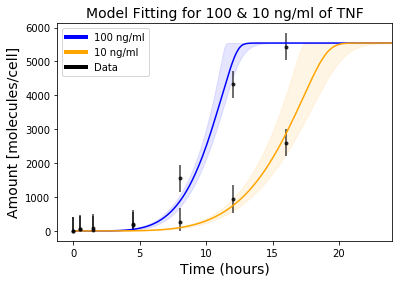

In [8]:
#FOR PLOTTING PERCENTILES 
x1001 = np.array([0, 30, 90, 270])
x1002 = np.array([480, 720, 960])
y1001 = np.array([0, 0.00885691708746097,0.0161886154261265,0.0373005242261882])
y1002 = np.array([0.2798939020159581, .7797294067, 0.98])
# plt.figure()

x101 = np.array([0, 30, 90, 270, 480])
x102 = np.array([720, 960])
y101 = np.array([0, 0.0106013664572332,0.00519576571714913,0.02967443048221,0.050022163974868])
y102 = np.array([0.17, 0.47])
# Combine the results dataframes into a single dataframe with a 'group' index,
# in addition to "simulation" and "time" indexes
df = pd.concat([result100n.dataframe, result10n.dataframe],
               keys=['mlkl100', 'mlkl10'],
               names=['group', 'simulation', 'time'])

# Add observable/group pairs as needed
obs_to_plot = {
    ('MLKLa_obs', 'mlkl100'): 'blue',
    ('MLKLa_obs', 'mlkl10'): 'orange'
}

lower_quantile = 0.1  # 10%
upper_quantile = 0.9  # 90%
median = 0.5

fig, ax = plt.subplots()
# plt.figure()
legend_keys = []
for obs_pair, colour in obs_to_plot.items():
    obs, group = obs_pair
    # Calculate 10%, 50%, and 90% quantiles for observable
    quantile_data = df[obs].loc[group].groupby(['time']).quantile(
        q=[lower_quantile, median, upper_quantile]).unstack()
    time_hrs = quantile_data.index / 60
    # Plot the median line (50% quantile) for the observable
    ax.plot(time_hrs, quantile_data.loc[:, median], color=colour)
    # Plot the 10% and 90% quantiles as an envelope
    ax.fill_between(time_hrs,
                    quantile_data.loc[:, lower_quantile],
                    quantile_data.loc[:, upper_quantile],
                    color=colour,
                    alpha=.1)

# Add the legend

# plt.legend([f'{obs} {group}' for obs, group in obs_to_plot.keys()])
plt.title('Model Fitting for 100 & 10 ng/ml of TNF',fontsize=14) # Title
plt.ylabel('Amount [molecules/cell]', fontsize = 14) # Y label
plt.xlabel('Time (hours)', fontsize = 14) # X label
plt.xlim(xmax =24)
# Add axis labels and title
# plt.set(xlabel='Time (hours)', ylabel='Amount [molecules/cell]', title=f'{model100.name}', fontsize = 14)
# Add grid
# ax.grid()
# plt.scatter(x101/60, y101*5544)
# plt.scatter(x101/60, y1002*5544)
# fig.savefig("necro_pydream_fitting_5k_5620_100_10tnf_wo_10_12hrs.pdf")
# plt.errorbar(x1001/60, y1001,
#              yerr=[(0, 0.00885691708746097,0.0161886154261265,0.0373005242261882),
#              (.10,.10,.10,.10)],
#                    fmt='.k', ecolor ='black', alpha = 0.75, label ='100 ng/ml', zorder = 2)
# plt.errorbar(x1002/60, y1002,
#              yerr= .10, fmt='.k', ecolor ='black', alpha = 0.75, label ='100 ng/ml', zorder = 2)
# plt.errorbar(x100/60, y10*5544, yerr=350, fmt='.k', ecolor = 'blue', alpha = 0.5, label ='10 ng/ml')
# plt.errorbar(x100/60, y100*5544, yerr=350, fmt='.k', ecolor ='green', alpha = 0.5, label ='100 ng/ml')
plt.errorbar(x1001/60, y1001*5544,
             yerr=[(0, 0.00885691708746097*5544,0.0161886154261265*5544,0.0373005242261882*5544),
             (400,400,400,400)],
                   fmt='.k', ecolor ='black', alpha = 0.75, label ='10 ng/ml', zorder = 2)
plt.errorbar(x1002/60, y1002*5544,
             yerr= 400, fmt='.k', ecolor ='black', alpha = 0.75, label ='10 ng/ml', zorder = 2)
plt.errorbar(x101/60, y101*5544,
             yerr=[(0, 0.0106013664572332*5544,0.00519576571714913*5544,0.02967443048221*5544,
                    0.050022163974868*5544),
             (400,400,400,400,400)],
                   fmt='.k', ecolor ='black', alpha = 0.75, label ='10 ng/ml', zorder = 2)
plt.errorbar(x102/60, y102*5544,
             yerr= 400, fmt='.k', ecolor ='black', alpha = 0.75, label ='10 ng/ml', zorder = 2)
custom_lines = [Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='orange', lw=4),
                Line2D([0], [0], color='black', lw=4)]
plt.legend(custom_lines, ['100 ng/ml', '10 ng/ml', 'Data'], prop={'size': 10}, loc = 'best')
plt.show()

In [ ]:
#11:24am
# random.seed(412873)
dp100 = PysbDomPath(model100, result100n)
signatures, paths = dp100.get_path_signatures(target='s36', type_analysis='production', 
                                             depth=25, dom_om=1.0)

In [ ]:
signatures.dissimilarity_matrix(n_jobs=1)

In [ ]:
#11:24am
# random.seed(412873)
dp100 = PysbDomPath(model100,'necro_pydream_5chns_5k_5620_100tnf.h5')
signatures100, paths100 = dp100.get_path_signatures(target='s36', type_analysis='production', 
                                             depth=15, dom_om=0.5)

In [ ]:
signatures100.dissimilarity_matrix(n_jobs=1)

In [ ]:
signatures.save('pydyno_5k_5620_10tnf_s36_d15_om05.h5')